# 基于wav2vec进行语义识别
使用pre-trained wav2vec 2.0进行语义识别
主要有三步：
1. 从音频信号中提取特征信息
2. frame-by-frame进行估计特征信息的类别
3. 根据概率进行推断

In [13]:
import os

import IPython
import matplotlib
import matplotlib.pyplot as plt
import requests
import torch
import torchaudio

matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]

torch.random.manual_seed(0)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

print(torch.__version__)
print(torchaudio.__version__)
print(device)

1.11.0
0.11.0
cuda:1


In [14]:
data_root_path = 'audio_study/data/study_data/'

In [15]:
SPEECH_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"  # noqa: E501
SPEECH_FILE = data_root_path + "speech.wav"

if not os.path.exists(SPEECH_FILE):
    os.makedirs("_assets", exist_ok=True)
    with open(SPEECH_FILE, "wb") as file:
        file.write(requests.get(SPEECH_URL).content)

## 创建wav2vec pipeline

In [16]:
# 通过torchaudio.pipelines导入pre-trained model的信息

bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
bundle._params

{'extractor_mode': 'group_norm',
 'extractor_conv_layer_config': [(512, 10, 5),
  (512, 3, 2),
  (512, 3, 2),
  (512, 3, 2),
  (512, 3, 2),
  (512, 2, 2),
  (512, 2, 2)],
 'extractor_conv_bias': False,
 'encoder_embed_dim': 768,
 'encoder_projection_dropout': 0.1,
 'encoder_pos_conv_kernel': 128,
 'encoder_pos_conv_groups': 16,
 'encoder_num_layers': 12,
 'encoder_num_heads': 12,
 'encoder_attention_dropout': 0.1,
 'encoder_ff_interm_features': 3072,
 'encoder_ff_interm_dropout': 0.0,
 'encoder_dropout': 0.1,
 'encoder_layer_norm_first': False,
 'encoder_layer_drop': 0.05,
 'aux_num_out': 29}

In [17]:
print('Sample Rate: ',bundle.sample_rate)
print('labels: ', bundle.get_labels())

Sample Rate:  16000
labels:  ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [38]:
len(bundle.get_labels())

29

In [18]:
# 下载对应模型
model = bundle.get_model().to(device)

print(model.__class__)

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [19]:
IPython.display.Audio(SPEECH_FILE)

In [20]:
# 使用torchaudio.load进行导入
# 如果采样率和pre-trained model的采样率不同 那么可以用resample方法进行重采样

In [31]:
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
waveform = waveform.to(device)
print('sample_rate: ', sample_rate)
waveform.shape

sample_rate:  16000


torch.Size([1, 54400])

In [32]:
if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform,sample_rate, bundle.sample_rate)

In [23]:
# 声学特征提取
with torch.inference_mode():
    features, _ = model.extract_features(waveform)

In [29]:
print('feature count: ', len(features))
# feature的数量代表了Transformer layer的层数
print('each feature shape: ', features[0].shape)
# 维度是[batch, time frame, feature dim]

feature count:  12
each feature shape:  torch.Size([1, 169, 768])


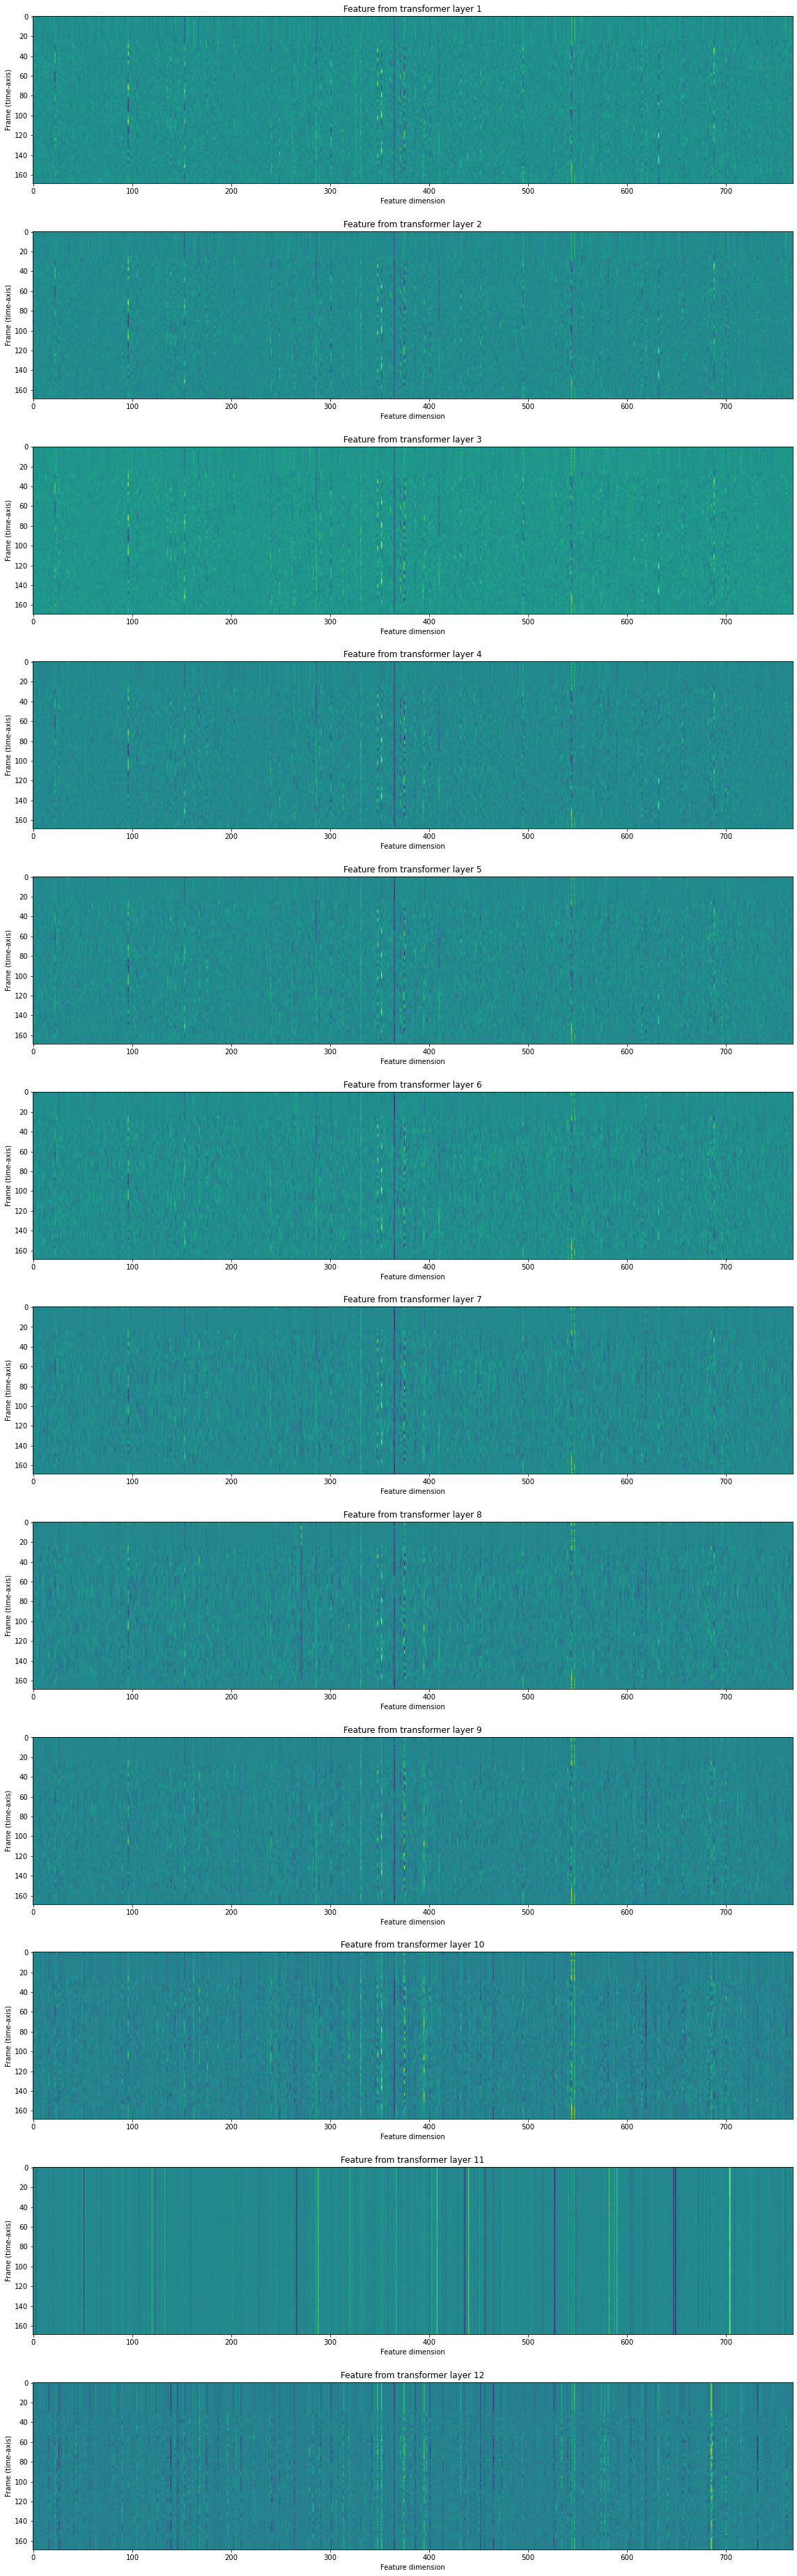

In [33]:
# 可视化每一层向量
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu())
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
plt.tight_layout()
plt.show()

In [34]:
# 进行推理
with torch.inference_mode():
    emission, _ = model(waveform)

In [37]:
print(emission.shape)
emission
# model推理的结果就是将向量变为29维 因为输出的总类别就是29维
# [batch, time frame, classes]

torch.Size([1, 169, 29])


tensor([[[15.2358, -1.8722, -3.2876,  ..., -6.8038, -6.9697, -7.4787],
         [15.2026, -1.9866, -3.3548,  ..., -6.7498, -6.8592, -7.5187],
         [15.2500, -2.0605, -3.2663,  ..., -6.7494, -6.8287, -7.5301],
         ...,
         [14.9062, -2.5285, -4.2244,  ..., -5.6469, -6.3332, -7.5236],
         [15.1731, -1.5069, -3.0879,  ..., -7.0562, -7.5710, -7.5639],
         [15.1200, -0.2939, -2.9559,  ..., -7.3614, -7.9231, -7.5754]]],
       device='cuda:1')

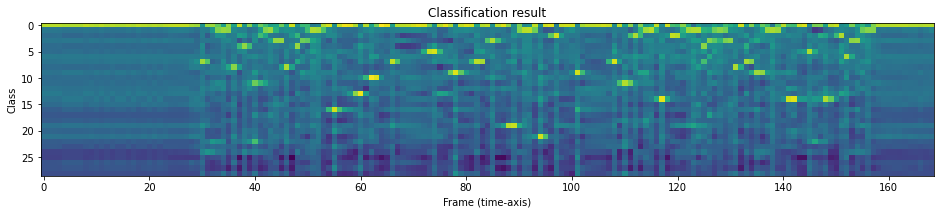

In [39]:
plt.imshow(emission[0].cpu().T)
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.show()

In [40]:
# 进行解码
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,] # 选出score最大的下标
        indices = torch.unique_consecutive(indices, dim=-1) # 因为是CTC 所以要去除重叠项
        indices = [i for i in indices if i != self.blank] # 当不为None时进行表刘
        return "".join([self.labels[i] for i in indices]) # 输出

In [41]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])

In [42]:
print(transcript)
IPython.display.Audio(SPEECH_FILE)
# 语义识别结果

I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT|
